In [1]:
import json
import requests
import curl

from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


%matplotlib inline


In [2]:
sns.set(style="white", palette="muted", color_codes=True)


In [ ]:
import config
username= config.username
password= config.password


In [4]:
import requests


# max_records is there so you can get back partial result sets, if you want. Useful for testing.
def get_all_course_data(max_records, category): 
    page_number = 1
    page_size = 100
    category=category
    more_records_exist = True
    all_courses = []

    while more_records_exist:
        api_response = get_courses(page_number, page_size, category)
        results = process_response(api_response)

        # add the new results to our aggregate set
        all_courses += results
    
        # if we get back fewer records than we asked for, we know we reached the end.
        # terminate the loop if we're at the end, or have hit our max.
        if len(results) < page_size or (max_records and len(all_courses) >= max_records):
            more_records_exist = False
        else:
            page_number += 1
            

    return all_courses

def get_courses(page_number, page_size, category): 
    courses_url = "https://www.udemy.com/api-2.0/courses/"

    query_params = {
        "page_size": page_size, 
        "page": page_number ,
        "category":category
    }

    credentials = (username, password)

    return requests.get(url=courses_url, auth=credentials, params=query_params).json()

def process_response(api_response):
    # api_response is a dictionary object which is a representation of the json structure.  
    courses = []

    # The json structure places all of the courses inside the results array
    for course in api_response['results']:
        # we add to the courses list tuples containing id, price, and headline.
        courses.append((course['id'], course['price'], course['headline']))
    return courses

def dataframing(result, category):
    df = pd.DataFrame.from_records(result, columns=['id', 'price', 'headline'])
    df['category']=category
    return df

In [5]:
%%time

categories=['Design','Marketing','Development','Music','Lifestyle']

df=pd.DataFrame(columns=['id', 'price', 'headline','category'])
for i in range(len(categories)):
    n = get_all_course_data(max_records=1000, category=categories[i])
    n = dataframing(n, category=categories[i])
    df = df.append([n])

    

CPU times: user 1.53 s, sys: 110 ms, total: 1.64 s
Wall time: 4min 9s


In [6]:
df.reset_index(inplace=True)


In [7]:
df.head()
df.drop(['index'],axis=1)

,id,price,headline,category
0,874012,$149.99,Learn the #1 most important building block of ...,Design
1,1259404,$194.99,Learn How to Draw People and Character Designs...,Design
2,438522,$194.99,Use Blender to create beautiful 3D models for ...,Design
3,1197206,$199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,1065056,$194.99,"Understand your audience, envision a creative ...",Design
...,...,...,...,...
4995,938226,$24.99,Three lessons take you from beginner to advanc...,Lifestyle
4996,700172,$59.99,Step-by-Step Guidelines From a Guy Who Has Tra...,Lifestyle
4997,677444,$29.99,Pick up stick shift quick and easy with these ...,Lifestyle
4998,1263356,$194.99,How to analyze positions and play chess like t...,Lifestyle


In [8]:
df.to_csv('data/data_U.csv')

Problem Statement

Hypothesis



## Data Cleaning

#### A description  of the dataset


In [9]:
data=df
data.describe()

,index
count,5000.000000
mean,499.500000
std,288.703862
min,0.000000
25%,249.750000
50%,499.500000
75%,749.250000
max,999.000000


#### data types

In [10]:
data.dtypes

index        int64
id          object
price       object
headline    object
category    object
dtype: object

In [11]:
data.category = data.category.astype(str)
data.headline = data.headline.astype(str)

In [18]:
data.price.replace({'Free': 0}, inplace=True)

In [19]:
data['price'].unique()

array(['149.99', '194.99', '199.99', '99.99', '29.99', '19.99', '94.99',
       '49.99', '174.99', '54.99', '179.99', '84.99', '119.99', '69.99',
       '109.99', '129.99', '44.99', '64.99', '39.99', '79.99', '154.99',
       '184.99', '24.99', '74.99', '139.99', '124.99', '89.99', '34.99',
       '59.99', '189.99', '104.99', '114.99', '134.99', '164.99',
       '159.99', '144.99', '169.99', 0, '$199.99', '$124.99', '$19.99',
       '$194.99', '$24.99', '$29.99', '$114.99', '$99.99', '$149.99',
       '$74.99', '$109.99', '$49.99', '$79.99', '$179.99', '$39.99',
       '$94.99', '$144.99', '$54.99', '$34.99', '$129.99', '$69.99',
       '$89.99', '$119.99', '$44.99', '$174.99', '$184.99', '$169.99',
       '$189.99', '$154.99', '$104.99', '$64.99', '$59.99', '$159.99',
       '$134.99', '$139.99', '$84.99', '$164.99'], dtype=object)

In [21]:
data['price'] = data['price'].str.replace('$', '')

In [22]:
data.price = data.price.astype(float)
data.id = data.id.astype(int)

In [32]:
data.loc[data['price'].isnull()]

,index,id,price,headline,category
1400,400,3045620,NaN,Learn how to create your email list and send e...,Marketing


In [34]:
data.fillna(0, inplace=True)

#### columns in the dataset

In [35]:
data.columns

Index(['index', 'id', 'price', 'headline', 'category'], dtype='object')

In [36]:
#### Convert Subject to Categorical Numbers

#data['subject'].value_counts() 
#data['subject_cat'] = data.subject
#data.subject_cat.replace({'Web Development': 4, 'Business Finance': 3, 'Musical Instruments':2, 'Graphic Design':1 }, inplace=True)
#data.subject_cat.value_counts()


## Exploratory Graphs

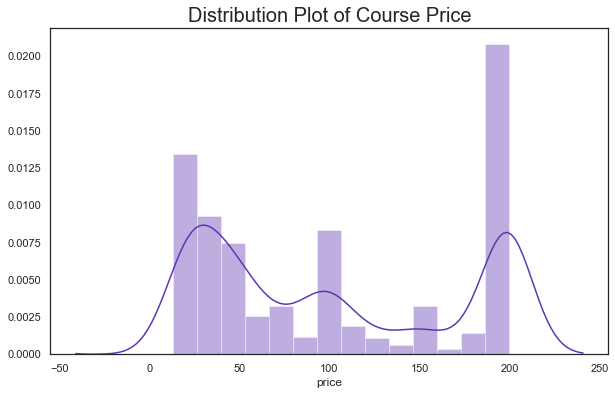

In [37]:

plt.figure(figsize= (10,6))
plt.title('Distribution Plot of Course Price', size=20)

sns.distplot(data['price'], bins=15, color='#5e35b1')
plt.show()

## Correlations

### boxplots

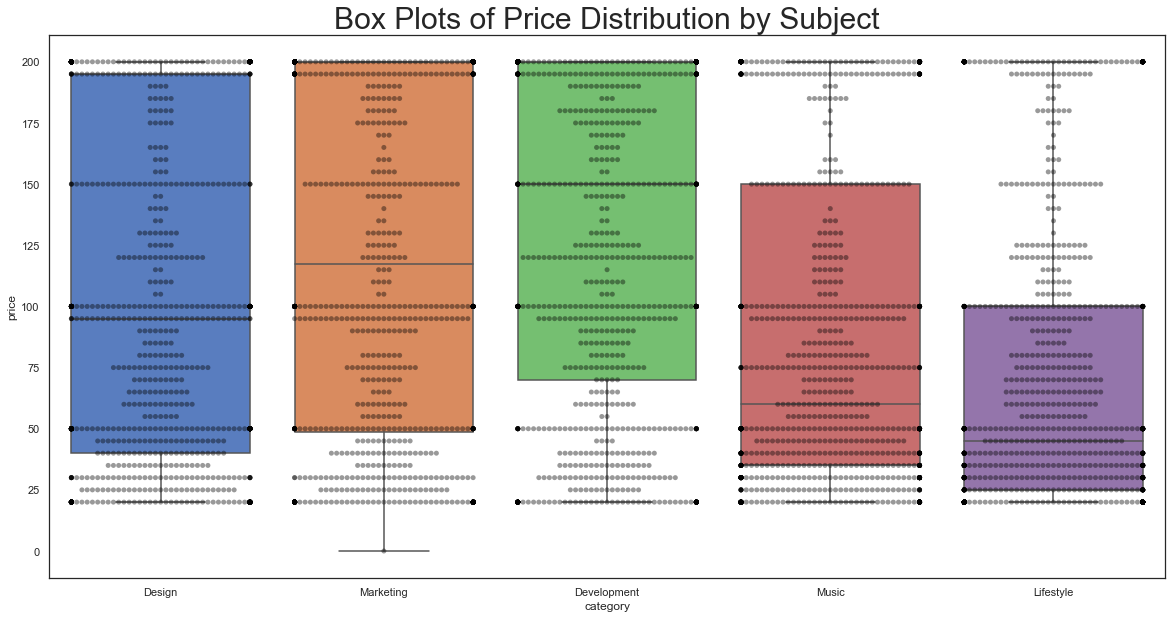

In [38]:

plt.figure(figsize=(20,10))
ax = sns.boxplot(x="category", y="price", data=data)
ax.set_title('Box Plots of Price Distribution by Subject', size=30)
ax = sns.swarmplot(x="category", y="price", data=data, color='black', alpha=.4)

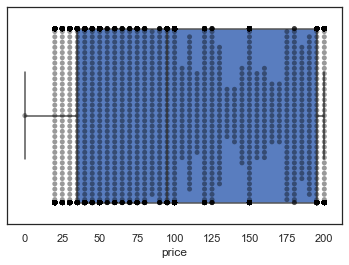

In [40]:
ax = sns.boxplot(data.price)
ax = sns.swarmplot(data.price, color='black', alpha=.4)

### segement data

In [41]:
data['price'].describe()

count    5000.000000
mean      102.523002
std        70.753302
min         0.000000
25%        34.990000
50%        94.990000
75%       194.990000
max       199.990000
Name: price, dtype: float64

#### sections for division into 3 categories is the distribution of prices from 0-25%, 25-75% and 75%-100%
#### sections for division into 2 categories split the price data evenly in half between min and max

In [42]:
data['price_bracket_3']=0
for i in range(0, len(data)):
    if (data.price[i] <= 20):
        data['price_bracket_3'][i]='1'
    elif (data.price[i] <= 96) and (data.price[i] >= 20):
        data['price_bracket_3'][i]='2'
    else:
        data['price_bracket_3'][i]='3'

/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
data['price_bracket_2']=0
for i in range(0, len(data)):
    if (data.price[i] <= 100):
        data['price_bracket_2'][i]=0
    else:
        data['price_bracket_2'][i]=1

/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### divided into 3 segements

In [44]:
data['price_bracket_3'].value_counts()

3    2376
2    1901
1     723
Name: price_bracket_3, dtype: int64

#### divided into 2 segments

In [45]:
data['price_bracket_2'].value_counts()

0    3018
1    1982
Name: price_bracket_2, dtype: int64

In [46]:
l = len(data[data.price_bracket_3==1])
l

723

In [47]:
 l = len(data[data.price_bracket_3==1])
 m = len(data[data.price_bracket_3==2])
 h =len(data[data.price_bracket_3==3])

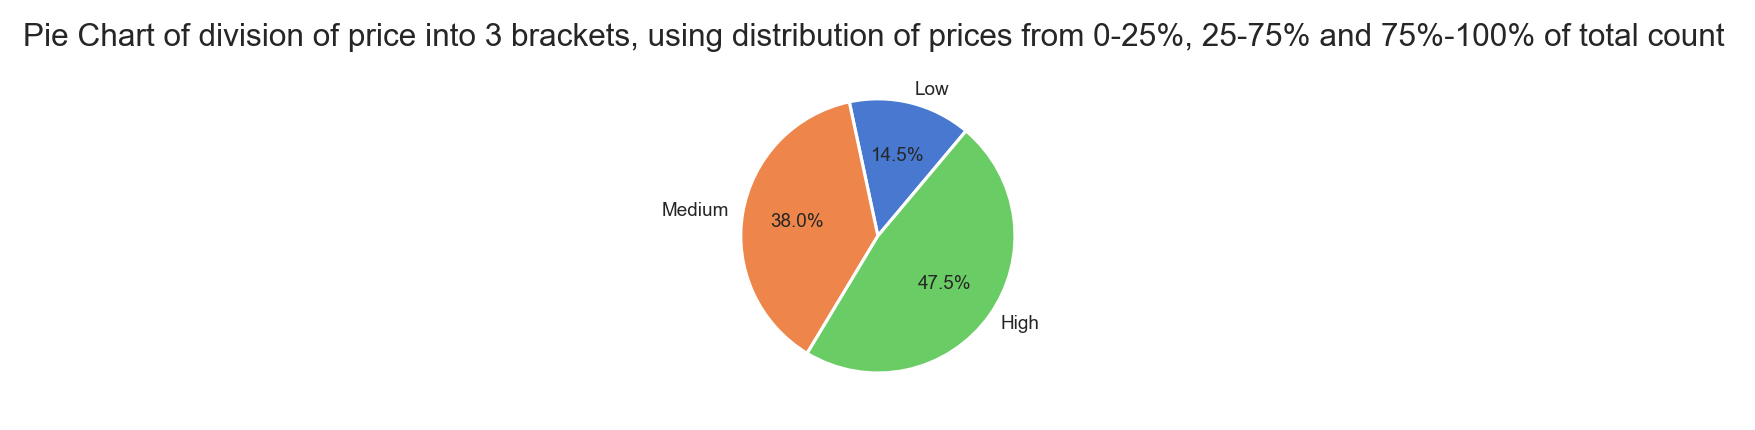

In [48]:
category_names = ['Low', 'Medium', 'High']
sizes = [l, m, h]
plt.figure(figsize= (2,2), dpi = 227)
figsize=50
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize' :6} , startangle=50,
       autopct= '%1.1f%%')
plt.title('Pie Chart of division of price into 3 brackets, using distribution of prices from 0-25%, 25-75% and 75%-100% of total count ', size=10)
plt.show()

In [49]:
 l = len(data[data.price_bracket_2==0])
 h = len(data[data.price_bracket_2==1])


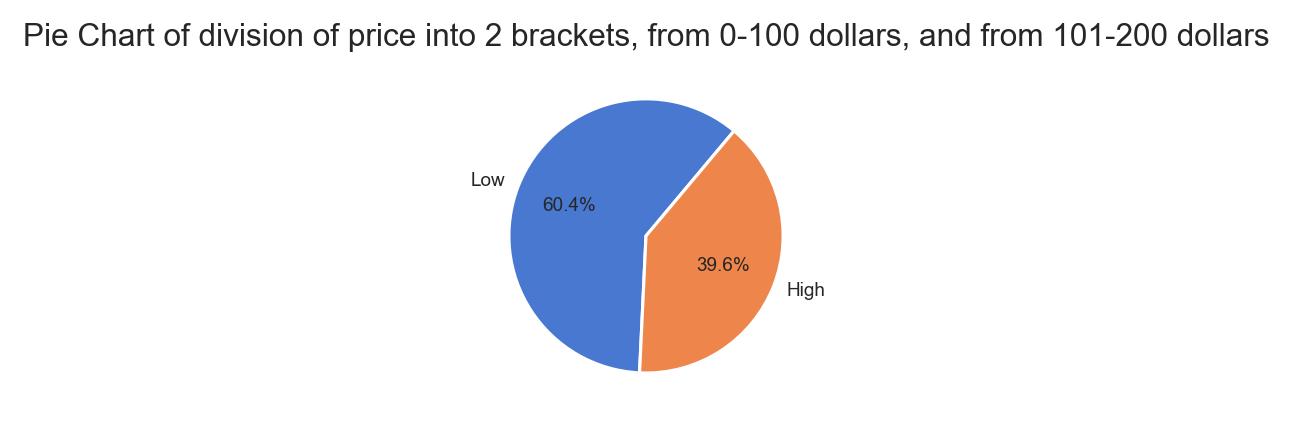

In [50]:
category_names = ['Low', 'High']
sizes = [l, h]
plt.figure(figsize= (2,2), dpi = 227)
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize' :6} , startangle=50,
       autopct= '%1.1f%%')
plt.title('Pie Chart of division of price into 2 brackets, from 0-100 dollars, and from 101-200 dollars', size=10)

plt.show()

In [51]:
data.describe()

,index,id,price,words,price_bracket_3,price_bracket_2
count,5000.000000,5.000000e+03,5000.000000,5000.0,5000.000000,5000.000000
mean,499.500000,1.184675e+06,102.523002,0.0,2.330600,0.396400
std,288.703862,7.056455e+05,70.753302,0.0,0.714567,0.489198
min,0.000000,4.715000e+03,0.000000,0.0,1.000000,0.000000
25%,249.750000,6.375655e+05,34.990000,0.0,2.000000,0.000000
50%,499.500000,1.128256e+06,94.990000,0.0,2.000000,0.000000
75%,749.250000,1.651316e+06,194.990000,0.0,3.000000,1.000000
max,999.000000,3.095720e+06,199.990000,0.0,3.000000,1.000000


In [52]:
## Save as csv

In [53]:
#data.to_csv('data/cleaned_data.csv')

# NLP Preprocessing

In [54]:
#define stopwords

In [94]:
my_stopwords = ['a','the','and','of','for','by','an', 'to', 'in', 'learn', 'how', 'from', 'with', 'your', 'you', 'course', 'build', 'use', 'using']

In [95]:
#make function for cleaning and tokenizing

In [96]:
def clean_message(message,
                 stop_words=set(my_stopwords)):
    
    words = word_tokenize(message.lower())
    
    filtered_words =[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append((word))
        
    return filtered_words

### NLP Exploration

In [97]:
data['words'] = 0
total_words =[]
for i in range(len(data['words'])):
    filtered_words = clean_message(data['headline'][i])
    data['words'][i] = filtered_words
    total_words.append(filtered_words)

/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [98]:
data.head(3)

,index,id,price,headline,category,words,price_bracket_3,price_bracket_2
0,0,874012,149.99,Learn the #1 most important building block of ...,Design,"[most, important, building, block, all, art]",3,1
1,1,1259404,194.99,Learn How to Draw People and Character Designs...,Design,"[draw, people, character, designs, professiona...",3,1
2,2,438522,194.99,Use Blender to create beautiful 3D models for ...,Design,"[blender, create, beautiful, models, video, ga...",3,1


In [99]:

flat_list = [item for sublist in total_words for item in sublist]

word_list = [''.join(word) for word in flat_list]
as_string = ' '.join(word_list)

unique_words= pd.Series(flat_list).value_counts()
print ('nr of unique words',  unique_words.shape[0])
unique_words.head()

nr of unique words 6349


create       474
music        430
design       421
on           412
marketing    410
dtype: int64

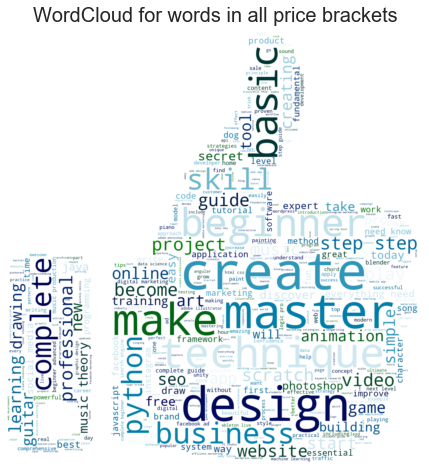

In [100]:
icon = Image.open('data/thumbs-up.png')
image_mask= Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array=np.array(image_mask) #converts image object to array

word_cloud = WordCloud(mask = rgb_array, background_color='white',
                      max_words=400, colormap='ocean')
word_cloud.generate(as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for words in all price brackets', size=20)
plt.show()


In [101]:
data_h = data[data.price_bracket_2 == 1]
data_h.reset_index(inplace=True)
data_h['words'] = 0
total_words_h =[]
for i in range(len(data_h['words'])):
    filtered_words = clean_message(data_h['headline'][i])
    data_h['words'][i] = filtered_words
    total_words_h.append(filtered_words)
    
flat_list = [item for sublist in total_words_h for item in sublist]

word_list = [''.join(word) for word in flat_list]
as_string = ' '.join(word_list)

unique_words= pd.Series(flat_list).value_counts()
print ('nr of unique words',  unique_words.shape[0])
unique_words.head()

/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

nr of unique words 3557


design       217
marketing    206
music        188
create       184
on           180
dtype: int64

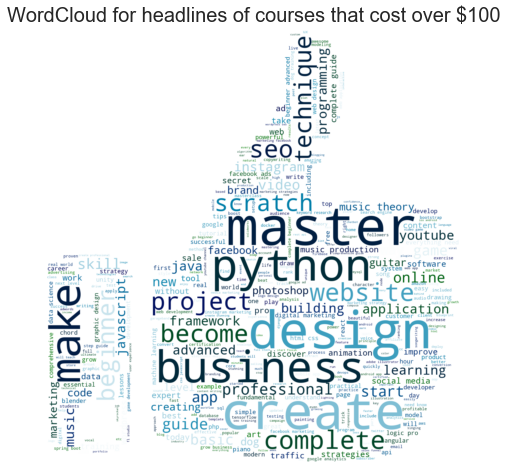

In [102]:
icon = Image.open('data/thumbs-up.png')
image_mask= Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array=np.array(image_mask) #converts image object to array

word_cloud = WordCloud(mask = rgb_array, background_color='white',
                      max_words=400, colormap='ocean')
word_cloud.generate(as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for headlines of courses that cost over $100', size=20)
plt.show()


In [103]:
data_1 = data[data.price_bracket_2 == 0]
data_1.reset_index(inplace=True)
data_1['words'] = 0
total_words_1 =[]
for i in range(len(data_1['words'])):
    filtered_words = clean_message(data_1['headline'][i])
    data_1['words'][i] = filtered_words
    total_words_1.append(filtered_words)
    
flat_list = [item for sublist in total_words_1 for item in sublist]

word_list = [''.join(word) for word in flat_list]
as_string = ' '.join(word_list)

unique_words= pd.Series(flat_list).value_counts()
print ('nr of unique words',  unique_words.shape[0])
unique_words.head()

/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mariumsultan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


nr of unique words 5152


create    290
music     242
on        232
this      222
step      218
dtype: int64

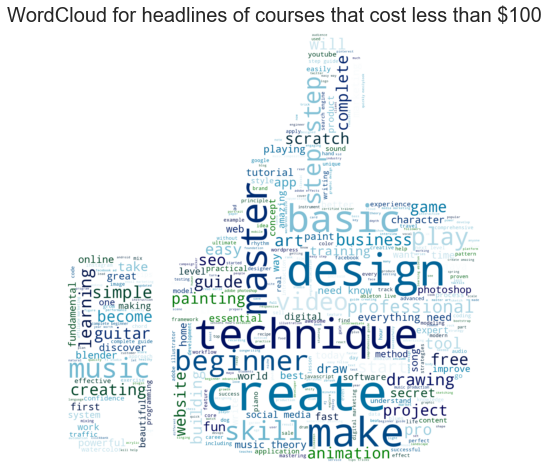

In [104]:
icon = Image.open('data/thumbs-up.png')
image_mask= Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array=np.array(image_mask) #converts image object to array

word_cloud = WordCloud(mask = rgb_array, background_color='white',
                      max_words=400, colormap='ocean')
word_cloud.generate(as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for headlines of courses that cost less than $100', size=20)
plt.show()

## Generate and Evaluate Predictive Model

## model with 2 categories

In [105]:
vectorizer =  CountVectorizer(stop_words=set(my_stopwords))
all_features = vectorizer.fit_transform(data.headline)

X_train, X_test, y_train, y_test = train_test_split(all_features,
                                                   data.price_bracket_2,
                                                   test_size=0.3,
                                                   random_state=100)

classifier = MultinomialNB()

classifier.fit(X_train,y_train)

y_hat = (classifier.predict(X_test))

nr_corr = (y_test == y_hat).sum()

preds = classifier.predict(X_test)

#and then test the accuracy


number_wrong = sum(abs(y_hat - y_test))
fraction_wrong = (number_wrong/(len(y_test)))




print ("the percent of predictions the model gets wrong is {:.2%}".format(fraction_wrong))
print ("the accuracy of the model is {:.2%}".format(1- fraction_wrong))
print ("the baseline accuracy would be 50%")
print ("the recall is {:.2%}".format(recall_score(y_test, preds)))
print ("the precision is {:.2%}".format(precision_score(y_test, preds)))




the percent of predictions the model gets wrong is 34.67%
the accuracy of the model is 65.33%
the baseline accuracy would be 50%
the recall is 56.90%
the precision is 56.15%


In [106]:
## model with 3 categories

In [107]:
vectorizer =  CountVectorizer(stop_words=set(my_stopwords))
all_features = vectorizer.fit_transform(data.headline)

X_train, X_test, y_train, y_test = train_test_split(all_features,
                                                   data.price_bracket_3,
                                                   test_size=0.2,
                                                   random_state=100)

classifier = MultinomialNB()

classifier.fit(X_train,y_train)

y_hat = (classifier.predict(X_test))

nr_corr = (y_test == y_hat).sum()

preds = classifier.predict(X_test)

#and then test the accuracy


number_wrong = sum(abs(y_hat - y_test))
fraction_wrong = (number_wrong/(len(y_test)))




print ("the percent of predictions the model gets wrong is {:.2%}".format(fraction_wrong))
print ("accuracy of the model is {:.2%}".format(1- fraction_wrong))
print ("the baseline accuracy would be 33%")

#print ("the recall is {:.2%}".format(recall_score(y_test, preds)))
#print ("the precision is {:.2%}".format(precision_score(y_test, preds)))




the percent of predictions the model gets wrong is 52.80%
accuracy of the model is 47.20%
the baseline accuracy would be 33%
